In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For statistical data visualization
%matplotlib inline
from matplotlib import style  # For setting the style of the visualizations
style.use('ggplot')
import re  # For regular expressions
from nltk.tokenize import word_tokenize  # For tokenizing words
from nltk.stem import PorterStemmer  # For word stemming
from nltk.corpus import stopwords  # For removing stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud  # For generating word clouds
from sklearn.feature_extraction.text import CountVectorizer  # For text vectorization
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.naive_bayes import MultinomialNB  # For Naive Bayes classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#Upload the dataset
df=pd.read_csv('BA - Assignment Part 2 data set.csv')

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33.0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,1.0,0.0,Initmates,Intimate,Intimates
1,1,1080,34.0,NaN,Love this dress! it's sooo pretty. i happene...,5.0,1.0,4.0,General,Dresses,Dresses
2,2,1077,60.0,Some major design flaws,I had such high hopes for this dress and reall...,3.0,0.0,0.0,General,Dresses,Dresses
3,3,1049,50.0,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,General Petite,Bottoms,Pants
4,4,847,47.0,Flattering shirt,This shirt is very flattering to all due to th...,5.0,1.0,6.0,General,Tops,Blouses


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20333 entries, 0 to 20332
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               20333 non-null  int64  
 1   Clothing ID              20333 non-null  int64  
 2   Age                      20332 non-null  float64
 3   Title                    17030 non-null  object 
 4   Review Text              19602 non-null  object 
 5   Rating                   20332 non-null  float64
 6   Recommended IND          20332 non-null  float64
 7   Positive Feedback Count  20332 non-null  float64
 8   Division Name            20322 non-null  object 
 9   Department Name          20322 non-null  object 
 10  Class Name               20322 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 1.7+ MB


In [ ]:
#Check for null value
null_counts = df.isnull().sum()
print(null_counts)


Unnamed: 0                    0
Clothing ID                   0
Age                           1
Title                      3303
Review Text                 731
Rating                        1
Recommended IND               1
Positive Feedback Count       1
Division Name                11
Department Name              11
Class Name                   11
dtype: int64


In [ ]:
#drop the null review text
df = df.dropna(subset=['Review Text'])

In [ ]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      2573
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                 9
Department Name               9
Class Name                    9
dtype: int64

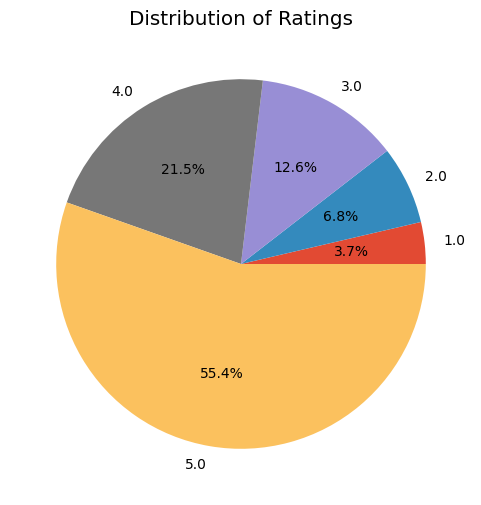

In [ ]:
import matplotlib.pyplot as plt

rating_counts = df.groupby('Rating')['Rating'].count()

plt.figure(figsize=(6, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Ratings')
plt.show()


In [ ]:
df.value_counts('Rating')

Rating
5.0    10861
4.0     4211
3.0     2474
2.0     1340
1.0      716
dtype: int64

In [ ]:
division_rating_counts = df.groupby(['Division Name', 'Rating'])['Rating'].count().unstack()
division_rating_percentages = division_rating_counts.apply(lambda x: round(100 * x / x.sum(), 2), axis=1).astype(str) +'%'


print("Division Name wise rating count:")
print(division_rating_counts)

print('='*52)

print("\nDivision Name wise rating percentage:")
print(division_rating_percentages)


Division Name wise rating count:
Rating          1.0  2.0   3.0   4.0   5.0
Division Name                             
General         416  823  1539  2520  6364
General Petite  256  449   801  1437  3735
Initmates        44   68   134   254   753

Division Name wise rating percentage:
Rating            1.0    2.0     3.0     4.0     5.0
Division Name                                       
General         3.57%  7.06%   13.2%  21.61%  54.57%
General Petite  3.83%  6.72%  11.99%  21.52%  55.93%
Initmates       3.51%  5.43%  10.69%  20.27%   60.1%


In [ ]:
for i in range(10):
    print(df['Review Text'].iloc[i],"\n")

Absolutely wonderful - silky and sexy and comfortable 

Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite. 

I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c 

I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments! 

This shi

In [ ]:
#Function for text data processing
def data_processing(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r"http\S+www\S+|https\S+", '', text, flags= re.MULTILINE) # Remove URLs
    text = re.sub(r'[^\w\s]','',text)#Remove punctuation
    text_tokens = word_tokenize(text)

    # Tokenize the text
    filtered_text = [w for w in text_tokens if not w in stop_words] # Remove stopwords
    return " ".join(filtered_text)

In [ ]:
for i in range(10):
    print(df['Review Text'].iloc[i],"\n")

Absolutely wonderful - silky and sexy and comfortable 

Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite. 

I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c 

I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments! 

This shi

In [ ]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['Review Text'] = df['Review Text'].apply(data_processing)

In [ ]:
#Function for stemming
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: stemming(x))

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33.0,NaN,absolutely wonderful silky sexy comfortable,4.0,1.0,0.0,Initmates,Intimate,Intimates
1,1,1080,34.0,NaN,love dress sooo pretty happened find store im ...,5.0,1.0,4.0,General,Dresses,Dresses
2,2,1077,60.0,Some major design flaws,high hopes dress really wanted work initially ...,3.0,0.0,0.0,General,Dresses,Dresses
3,3,1049,50.0,My favorite buy!,love love love jumpsuit fun flirty fabulous ev...,5.0,1.0,0.0,General Petite,Bottoms,Pants
4,4,847,47.0,Flattering shirt,shirt flattering due adjustable front tie perf...,5.0,1.0,6.0,General,Tops,Blouses


In [ ]:
# Assign rating 4,5 as Positive 3 as Neutral, and 2,1 as Negative sentiment using lambda function

df['Sentiment'] = df['Rating'].apply(lambda x: 'Positive' if x in [4, 5] else 'Neutral' if x == 3 else 'Negative')
df.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
0,0,767,33.0,NaN,absolutely wonderful silky sexy comfortable,4.0,1.0,0.0,Initmates,Intimate,Intimates,Positive
1,1,1080,34.0,NaN,love dress sooo pretty happened find store im ...,5.0,1.0,4.0,General,Dresses,Dresses,Positive
2,2,1077,60.0,Some major design flaws,high hopes dress really wanted work initially ...,3.0,0.0,0.0,General,Dresses,Dresses,Neutral
3,3,1049,50.0,My favorite buy!,love love love jumpsuit fun flirty fabulous ev...,5.0,1.0,0.0,General Petite,Bottoms,Pants,Positive
4,4,847,47.0,Flattering shirt,shirt flattering due adjustable front tie perf...,5.0,1.0,6.0,General,Tops,Blouses,Positive


In [ ]:
#Summarize the overall sentiment distribu-on
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)


Positive    15072
Neutral      2474
Negative     2056
Name: Sentiment, dtype: int64


In [ ]:
#Balance the sentiment

from sklearn.utils import resample

df_majority = df[df['Sentiment'] == 'Positive']
df_minority = df[df['Sentiment'] == 'Neutral']
df_minority1 = df[df['Sentiment'] == 'Negative']

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_minority1_upsampled = resample(df_minority1, replace=True, n_samples=len(df_majority), random_state=42)

# Combine majority and upsampled minority classes
df_balanced = pd.concat([df_majority, df_minority_upsampled, df_minority1_upsampled])

# Display new class counts
df_balanced['Sentiment'].value_counts()

Positive    15072
Neutral     15072
Negative    15072
Name: Sentiment, dtype: int64

In [ ]:
X = df_balanced['Review Text']  # Features
y = df_balanced['Sentiment']  # Target


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print("Size of x_train: ",(X_train.shape))
print("Size of y_train: ",(y_train.shape))
print("Size of x_test: ",(X_test.shape))
print("Size of y_test: ",(y_test.shape))

Size of x_train:  (36172, 17739)
Size of y_train:  (36172,)
Size of x_test:  (9044, 17739)
Size of y_test:  (9044,)


Train Accuracy: 0.8467322791109145
Test Accuracy: 0.8220919946926138
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.84      3036
     Neutral       0.74      0.81      0.77      2944
    Positive       0.89      0.84      0.86      3064

    accuracy                           0.82      9044
   macro avg       0.82      0.82      0.82      9044
weighted avg       0.83      0.82      0.82      9044



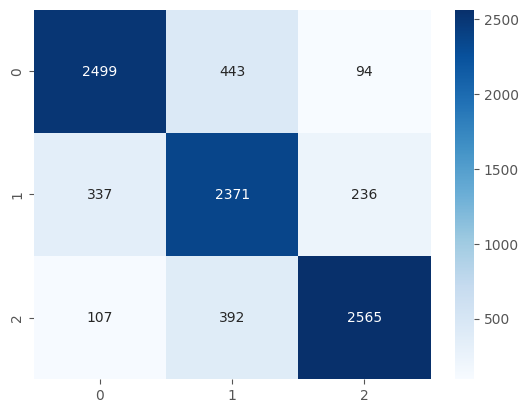

In [ ]:
#Build a  naive base model

import matplotlib.pyplot as plt
# Naive Bayes model

# Instantiate the Multinomial Naive Bayes classifier
naive_bayes = MultinomialNB()

# Train the model on the training set
naive_bayes.fit(X_train, y_train)

y_pred_train_nb = naive_bayes.predict(X_train)
y_pred_test_nb = naive_bayes.predict(X_test)

# Evaluate and print the accuracy
print("Train Accuracy:", accuracy_score(y_train, y_pred_train_nb))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_nb))
# Classification report
print(classification_report(y_test, y_pred_test_nb))

# Compute and plot the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_test_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.show()


# Summary
The code performs sentiment analysis on a dataset of reviews. It cleans and preprocesses the text data, handles imbalanced classes, and trains a Naive Bayes model to classify the sentiment of the reviews. The code also evaluates the model's performance and visualizes the results.

Here's a summary of the steps:

1. **Data Processing:**
    - Convert text to lowercase, remove URLs and punctuation.
    - Tokenize the text and remove stopwords.

2. **Stemming:**
    - Apply stemming to the tokens.

3. **Sentiment Assignment:**
    - Assign sentiment labels based on rating: Positive (4, 5), Neutral (3), Negative (2, 1).

4. **Balancing the Dataset:**
    - Upsample minority classes (Neutral and Negative) to match the majority class (Positive).

5. **Model Training and Evaluation:**
    - Use CountVectorizer to transform text data into numerical features.
    - Split the data into training and test sets.
    - Train a Multinomial Naive Bayes model on the training set.
    - Evaluate the model's accuracy and print a classification report.

6. **Visualization:**
    - Plot a confusion matrix to visualize the model's performance on different sentiment classes.

In summary, this project demonstrates a complete workflow for performing sentiment analysis on textual data using Python libraries. It includes data cleaning, preprocessing, feature engineering, model training, evaluation.